# Enhancing Performance of Ensemble Models through Cost-Sensitive Learning, Tree-Based Pazen Estimator, and x-AI for Model Interpretation

**Author:** Tam Luong Thanh  
**Environment:** Google Colab  
**Libraries:** numpy, pandas, matplotlib, seaborn, scikit-learn, imbalanced-learn, optuna, shap, ...  

---

## Project Overview

This project aims to enhance the performance of machine learning models, particularly ensemble models, through a combination of:

1. **Data-level processing**:
   - **Resampling techniques** to balance data distribution: SMOTE, ADASYN  
   - **Feature selection methods**: Wrapper approaches such as Recursive Feature Elimination with Cross-Validation (RFE-CV) and Sequential Feature Selection (SFS)  

2. **Algorithm-level optimization**:
   - **Cost-sensitive learning** to handle imbalanced datasets  
   - **Ensemble methods** for boosting predictive performance  

3. **Hybrid-level approaches**:
   - Combining feature selection with resampling  
   - Combining feature selection with class weight adjustment  

4. **Hyperparameter optimization**:
   - Performed using Tree-structured Parzen Estimator (TPE) via **Optuna**  

5. **Model interpretation**:
   - Using **SHAP** to explain predictions and understand feature importance  

6. **Overfitting check**:
   - Evaluate model robustness across cross-validation folds  

---

## Structure of the Notebook

1. **Import Libraries** – Load all required packages and set visualization styles.  
2. **Data Preparation** – Load, clean, and preprocess the dataset.  
3. **Modeling** – Train and evaluate models at different levels:  
   - No processing  
   - Data-level processing  
   - Algorithm-level optimization  
   - Hybrid-level methods  
4. **Hyperparameter Tuning** – Optimize models using TPE.  
5. **Model Explanation** – Interpret results with SHAP.  
6. **Overfitting Check** – Validate model generalization performance.  

---

This notebook provides a comprehensive workflow for improving ensemble and single models in imbalanced datasets, combining state-of-the-art techniques for performance enhancement and explainability.

# **Import Library**

* Install **numpy**, **pandas**, **matplotlib**, and **seaborn**
* Use **scikit-learn** for data preparation, training, and evaluation
* Install **imbalanced-learn** for resampling techniques
* Install **mlxtend** for Sequential features selection
* Install model-specific libraries: **xgboost, lightgbm**
* Import **optuna** and apply TPE for hyperparameter optimization

In [ ]:
!pip install catboost optuna imbalanced-learn mlxtend

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, learning_curve
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, make_scorer
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE, ADASYN

In [ ]:
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
import optuna
import optuna.visualization.matplotlib as vis_matplotlib
import optuna.visualization as vis

import shap

In [ ]:
from google.colab import files

# **Data Preparation**

In [ ]:
data = pd.read_csv("churnecommerce.csv")

In [ ]:
data

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,160
1,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,121
2,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120
3,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134
4,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,0,10.0,Computer,1,30.0,Credit Card,Male,3.0,2,Laptop & Accessory,1,Married,6,0,18.0,1.0,2.0,4.0,151
5626,0,13.0,Mobile Phone,1,13.0,Credit Card,Male,3.0,5,Fashion,5,Married,6,0,16.0,1.0,2.0,NaN,225
5627,0,1.0,Mobile Phone,1,11.0,Debit Card,Male,3.0,2,Laptop & Accessory,4,Married,3,1,21.0,1.0,2.0,4.0,186
5628,0,23.0,Computer,3,9.0,Credit Card,Male,4.0,5,Laptop & Accessory,4,Married,4,0,15.0,2.0,2.0,9.0,179


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        5630 non-null   int64  
 1   Tenure                       5366 non-null   float64
 2   PreferredLoginDevice         5630 non-null   object 
 3   CityTier                     5630 non-null   int64  
 4   WarehouseToHome              5379 non-null   float64
 5   PreferredPaymentMode         5630 non-null   object 
 6   Gender                       5630 non-null   object 
 7   HourSpendOnApp               5375 non-null   float64
 8   NumberOfDeviceRegistered     5630 non-null   int64  
 9   PreferedOrderCat             5630 non-null   object 
 10  SatisfactionScore            5630 non-null   int64  
 11  MaritalStatus                5630 non-null   object 
 12  NumberOfAddress              5630 non-null   int64  
 13  Complain          

Handling missing data:
* Use mode for categorical data
* Use median for continuous numerical data

In [ ]:
num_cols = data.select_dtypes(include=[np.number]).columns
cat_cols = data.select_dtypes(exclude=[np.number]).columns

data_num = data[num_cols].copy()
for col in num_cols:
    median_value = data_num[col].median()
    data_num[col].fillna(median_value, inplace=True)

data_cat = data[cat_cols].copy()
for col in cat_cols:
    mode_value = data_cat[col].mode()[0]
    data_cat[col].fillna(mode_value, inplace=True)

# Combine back together
data = pd.concat([data_num, data_cat], axis=1)
data

/tmp/ipython-input-2805966362.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_num[col].fillna(median_value, inplace=True)
/tmp/ipython-input-2805966362.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
0,1,4.0,3,6.0,3.0,3,2,9,1,11.0,1.0,1.0,5.0,160,Mobile Phone,Debit Card,Female,Laptop & Accessory,Single
1,1,9.0,1,8.0,3.0,4,3,7,1,15.0,0.0,1.0,0.0,121,Phone,UPI,Male,Mobile,Single
2,1,9.0,1,30.0,2.0,4,3,6,1,14.0,0.0,1.0,3.0,120,Phone,Debit Card,Male,Mobile,Single
3,1,0.0,3,15.0,2.0,4,5,8,0,23.0,0.0,1.0,3.0,134,Phone,Debit Card,Male,Laptop & Accessory,Single
4,1,0.0,1,12.0,3.0,3,5,3,0,11.0,1.0,1.0,3.0,130,Phone,CC,Male,Mobile,Single
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,0,10.0,1,30.0,3.0,2,1,6,0,18.0,1.0,2.0,4.0,151,Computer,Credit Card,Male,Laptop & Accessory,Married
5626,0,13.0,1,13.0,3.0,5,5,6,0,16.0,1.0,2.0,3.0,225,Mobile Phone,Credit Card,Male,Fashion,Married
5627,0,1.0,1,11.0,3.0,2,4,3,1,21.0,1.0,2.0,4.0,186,Mobile Phone,Debit Card,Male,Laptop & Accessory,Married
5628,0,23.0,3,9.0,4.0,5,4,4,0,15.0,2.0,2.0,9.0,179,Computer,Credit Card,Male,Laptop & Accessory,Married


One-hot encoding for categorical data

In [ ]:
cat_data = data.select_dtypes(include='object')
encoded = pd.get_dummies(cat_data,drop_first=True)

data_enc = pd.concat([data.drop(cat_data.columns, axis=1), encoded], axis=1)

In [ ]:
print(data_enc.shape)
data_enc.columns

(5630, 30)


Index(['Churn', 'Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress',
       'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount',
       'PreferredLoginDevice_Mobile Phone', 'PreferredLoginDevice_Phone',
       'PreferredPaymentMode_COD', 'PreferredPaymentMode_Cash on Delivery',
       'PreferredPaymentMode_Credit Card', 'PreferredPaymentMode_Debit Card',
       'PreferredPaymentMode_E wallet', 'PreferredPaymentMode_UPI',
       'Gender_Male', 'PreferedOrderCat_Grocery',
       'PreferedOrderCat_Laptop & Accessory', 'PreferedOrderCat_Mobile',
       'PreferedOrderCat_Mobile Phone', 'PreferedOrderCat_Others',
       'MaritalStatus_Married', 'MaritalStatus_Single'],
      dtype='object')

In [ ]:
X=data_enc.drop(['Churn'],axis=1)
y=data_enc['Churn']

In [ ]:
data['Churn'].value_counts()

,count
Churn,
0,4682
1,948


# **Modeling**

In this section, the work is divided into several parts:

- **No process**: Train and test directly on preprocessed data, comparing Ensemble models (at the algorithm level) and Single models.  
- **Data level**:  
  * Data distribution: **SMOTE, ADASYN**  
  * Feature adjustment: Wrapper methods such as **RFE-CV** & **SFS**  
- **Algorithm level**:  
  * **Cost-sensitive learning**  
  * **Ensemble models**  
- **Hybrid level**: Applied to both ensemble and single models  
  * **Feature selection + Resampling**  
  * **Feature selection + Class weight**

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
modelsNoCW = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

In [ ]:
neg = sum(y==0)
pos = sum(y==1)
scale_pos_weight = neg / pos

modelsCW = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        scale_pos_weight=scale_pos_weight
    ),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42)
}

In [ ]:
metrics = ['Model', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']

processes = [
    "Noprocess", "Smote", "Adasyn", "CW", "RFE", "SFS",
    "RFECW", "RFESmote", "RFEAdasyn", "SFSCW", "SFSSmote", "SFSAdasyn"
]

results = {proc: pd.DataFrame(columns=metrics) for proc in processes}

In [ ]:
def sfs_selector(estimator, **kwargs):
    return SFS(estimator, k_features='best', forward=True, floating=False, scoring='recall', cv=5, n_jobs=-1)

In [ ]:
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)

In [ ]:
def evaluate_and_store(models_dict, X, y, skf, results_df, metrics, resampler=None, feature_selector=None):
    """
    Evaluate models, calculate the average of metrics, and store the results in a DataFrame.
    Supports resamplers (SMOTE, ADASYN) and feature selectors (RFE, RFECV, SFS).
    
    models_dict: dict containing model names and model objects
    X, y: data
    skf: StratifiedKFold object
    results_df: empty or pre-defined DataFrame to store results
    metrics: list of metric names (DataFrame columns)
    resampler: resampler object (SMOTE, ADASYN, etc.) or None
    feature_selector: selector class (RFECV, RFE, SFS, ...) or None
    
    Returns: results_df with averaged results
    """
    for name, model in models_dict.items():
        scores = {metric: [] for metric in metrics[1:]}  # exclude 'Model'
        
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # If a resampler is provided, apply it to the training set
            if resampler is not None:
                X_train, y_train = resampler.fit_resample(X_train, y_train)

            # If a feature selector is provided, fit on training set and transform both train/test sets
            if feature_selector is not None:
                selector = feature_selector(
                    estimator=model, 
                    step=1, 
                    cv=StratifiedKFold(n_splits=5), 
                    scoring='recall', 
                    n_jobs=-1
                )
                selector.fit(X_train, y_train)
                X_train = selector.transform(X_train)
                X_test = selector.transform(X_test)

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else y_pred

            scores['Accuracy'].append(accuracy_score(y_test, y_pred))
            scores['Balanced Accuracy'].append(balanced_accuracy_score(y_test, y_pred))
            scores['Precision'].append(precision_score(y_test, y_pred))
            scores['Recall'].append(recall_score(y_test, y_pred))
            scores['F1-Score'].append(f1_score(y_test, y_pred))
            try:
                scores['ROC AUC'].append(roc_auc_score(y_test, y_prob))
            except:
                scores['ROC AUC'].append(np.nan)
        
        # Store the average metrics into the DataFrame
        results_df = pd.concat([
            results_df,
            pd.DataFrame({
                'Model': [name],
                **{metric: [np.mean(values)] for metric, values in scores.items()}
            })
        ], ignore_index=True)
    
    return results_df

## No Process

In [ ]:
results['Noprocess'] = evaluate_and_store(modelsNoCW, X, y, skf, results['Noprocess'], metrics)

## Data - level: Data distribution

### SMOTE

In [ ]:
results['Smote'] = evaluate_and_store(modelsNoCW, X, y, skf, results['Smote'], metrics, resampler=smote)

### ADASYN

In [ ]:
results['Adasyn'] = evaluate_and_store(modelsNoCW, X, y, skf, results['Adasyn'], metrics, resampler=adasyn)

## Algorithm-level: Cost-sensitive learning

In [ ]:
results['CW'] = evaluate_and_store(modelsCW, X, y, skf, results['CW'], metrics)

## Data level: Feature Dimension: Wrapper method

### Recursive Features Elimination with cross validation

In [ ]:
results['RFE'] = evaluate_and_store(modelsNoCW, X, y, skf, results['RFE'], metrics, feature_selector=RFECV)

### Sequential Features Selection (SFS)

In [ ]:
results['SFS'] = evaluate_and_store(modelsNoCW, X, y, skf, results['SFS'], metrics, feature_selector=sfs_selector)

## Hybrid approaches

### RFECV - CW

In [ ]:
results['RFECW'] = evaluate_and_store(modelsCW, X, y, skf, results['RFECW'], metrics, feature_selector=RFECV)

### RFECV - SMOTE

In [ ]:
results['RFESmote'] = evaluate_and_store(modelsNoCW, X, y, skf, results['RFESmote'], metrics, resampler=smote, feature_selector=RFECV)

### RFECV - ADASYN

In [ ]:
results['RFEAdasyn'] = evaluate_and_store(modelsNoCW, X, y, skf, results['RFEAdasyn'], metrics, resampler=adasyn, feature_selector=RFECV)

### SFS CW

In [ ]:
results['SFSCW'] = evaluate_and_store(modelsCW, X, y, skf, results['SFSCW'], metrics, feature_selector=sfs_selector)

### SFS SMOTE

In [ ]:
results['SFSSmote'] = evaluate_and_store(modelsNoCW, X, y, skf, results['SFSSmote'], metrics, resampler=smote, feature_selector=sfs_selector)

### SFS ADASYN

In [ ]:
results['SFSAdasyn'] = evaluate_and_store(modelsNoCW, X, y, skf, results['SFSAdasyn'], metrics, resampler=adasyn, feature_selector=sfs_selector)

## Downloading results

In [ ]:
for proc_name, df in results.items():
    print(f"\n=== Results for {proc_name} ===")
    print(df)

In [ ]:
output_file = "model_results.xlsx"

with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
    for proc_name, df in results.items():
        safe_name = "".join(c if c.isalnum() else "_" for c in proc_name[:31])
        df.to_excel(writer, sheet_name=safe_name, index=False)
files.download(output_file)

# **Hyperparameter optimization**

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "scale_pos_weight": scale_pos_weight,
        "random_state": 42,
        "eval_metric": "logloss",
        "use_label_encoder": False
    }

    model = XGBClassifier(**params)
    scoring = {"recall": make_scorer(recall_score)}
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return np.mean(scores["test_recall"])

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)

best_params = study.best_params.copy()
best_params.update({
    "scale_pos_weight": scale_pos_weight,
    "random_state": 42,
    "eval_metric": "logloss",
    "use_label_encoder": False
})

model = XGBClassifier(**best_params)

scoring = {
    "accuracy": make_scorer(accuracy_score),
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score),
    "roc_auc": make_scorer(roc_auc_score)
}

scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)

df_results = pd.DataFrame([{
    "accuracy": np.mean(scores["test_accuracy"]),
    "balanced_accuracy": np.mean(scores["test_balanced_accuracy"]),
    "precision": np.mean(scores["test_precision"]),
    "recall": np.mean(scores["test_recall"]),
    "f1-score": np.mean(scores["test_f1"]),
    "roc_auc": np.mean(scores["test_roc_auc"]),
    "best_params": str(best_params)
}])

df_results

In [ ]:
df_results

,accuracy,balanced_accuracy,precision,recall,f1-score,roc_auc,best_params
0,0.97833,0.95963,0.939355,0.931434,0.935145,0.95963,"{'n_estimators': 323, 'max_depth': 9, 'learnin..."


In [ ]:
df_results.to_excel("results.xlsx", index=False)
from google.colab import files
files.download("results.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_results['best_params'].values

array(["{'n_estimators': 323, 'max_depth': 9, 'learning_rate': 0.035012308132068994, 'subsample': 0.9460126686315559, 'colsample_bytree': 0.7969754254702797, 'scale_pos_weight': np.float64(4.938818565400844), 'random_state': 42, 'eval_metric': 'logloss', 'use_label_encoder': False}"],
      dtype=object)

In [ ]:
plt.style.use("seaborn-v0_8")
plt.rcParams.update({
    "figure.figsize": (8,5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

/tmp/ipython-input-3275313980.py:1: ExperimentalWarning:

optuna.visualization.matplotlib._slice.plot_slice is experimental (supported from v2.2.0). The interface can change in the future.



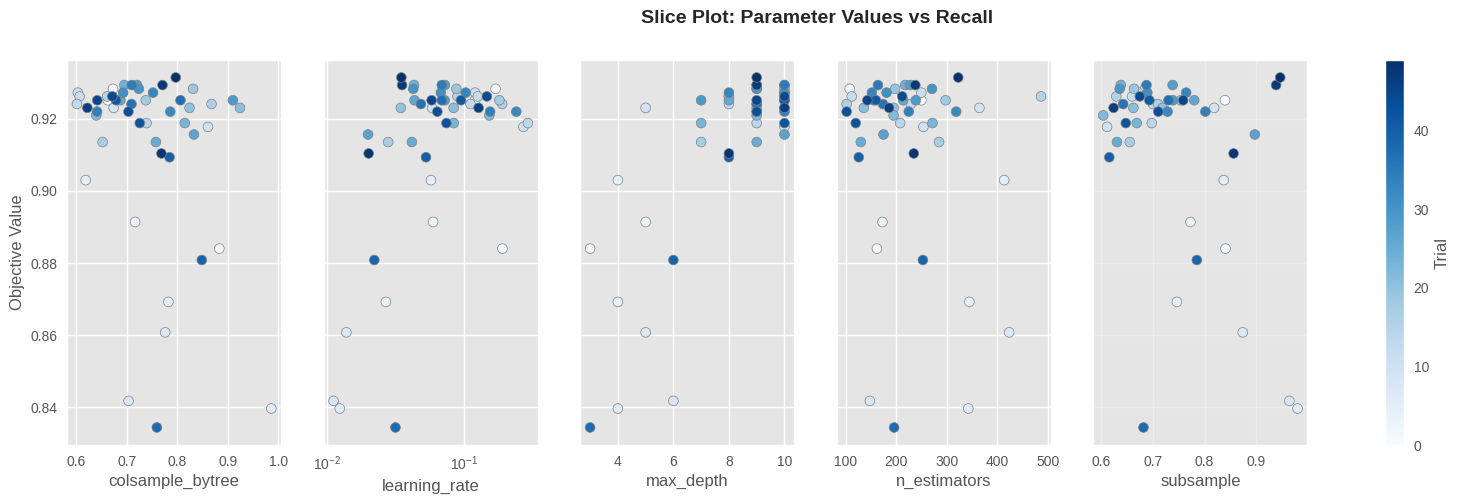

In [ ]:
fig3 = vis_matplotlib.plot_slice(study)
plt.suptitle("Slice Plot: Parameter Values vs Recall", fontsize=14, weight="bold")
plt.grid(alpha=0.3)
plt.show()

/tmp/ipython-input-4122447762.py:21: ExperimentalWarning:

optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



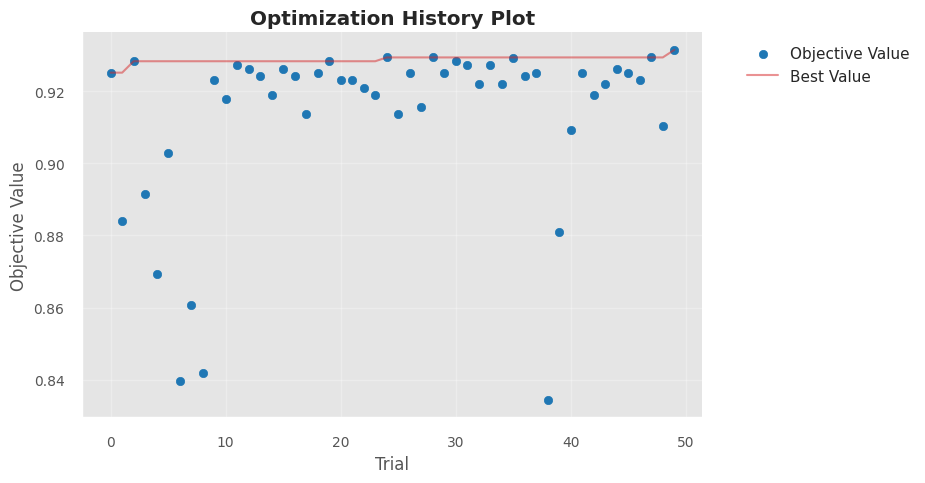

/tmp/ipython-input-4122447762.py:30: ExperimentalWarning:

optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



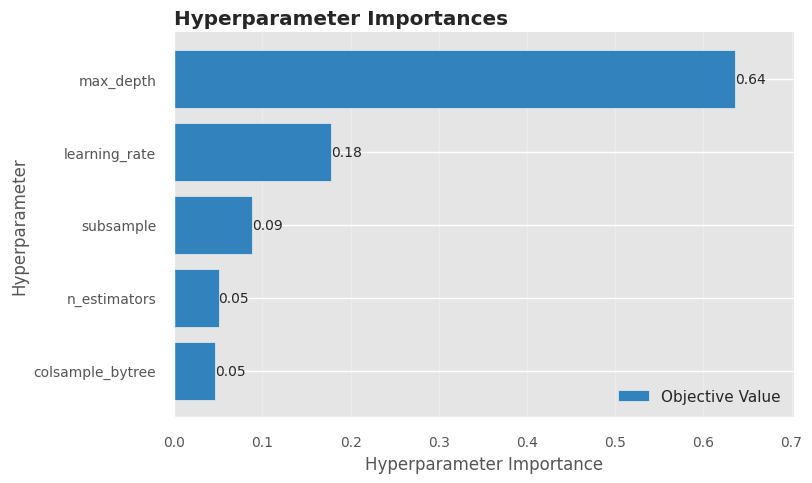

In [ ]:
fig1 = vis_matplotlib.plot_optimization_history(study)
plt.grid(alpha=0.3)
sns.despine()
plt.show()

fig2 = vis_matplotlib.plot_param_importances(study)
plt.grid(alpha=0.3, axis="x")
sns.despine()
plt.show()

In [ ]:
fig4 = vis.plot_contour(study)
fig4.update_layout(
    width=1200,
    height=1000
    )
fig4.show()

# **Model explaination**

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:24:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


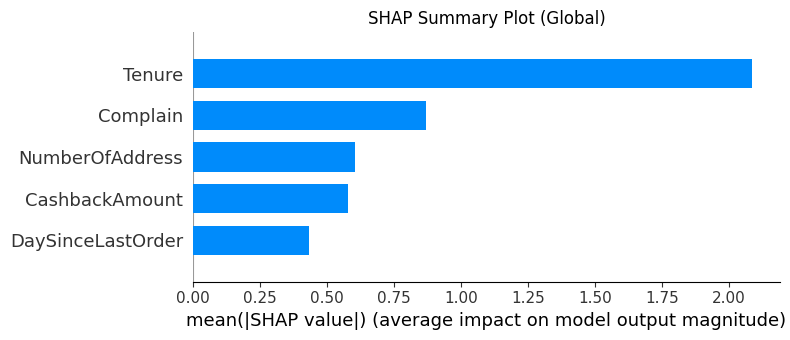

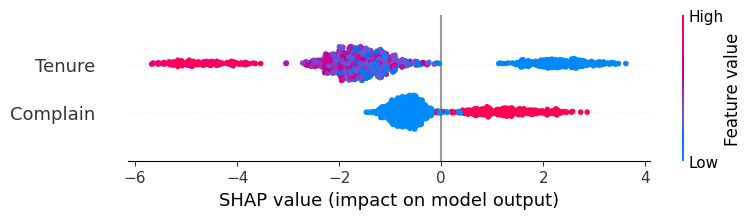

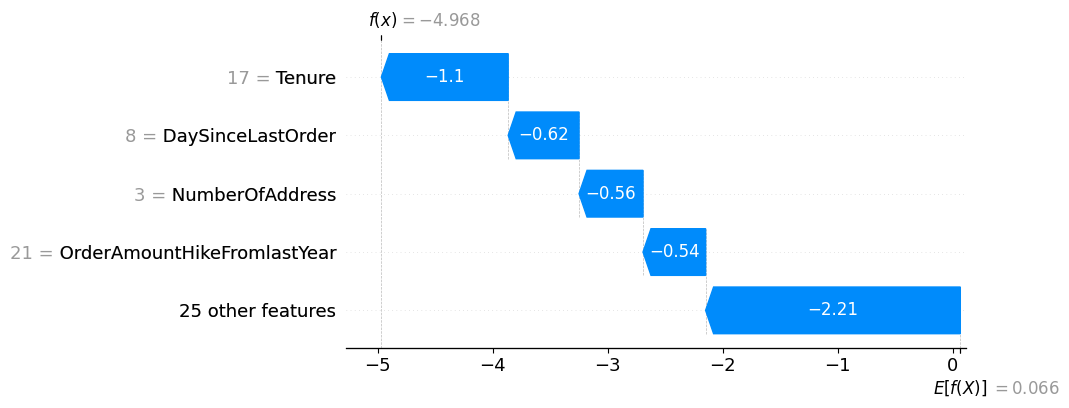

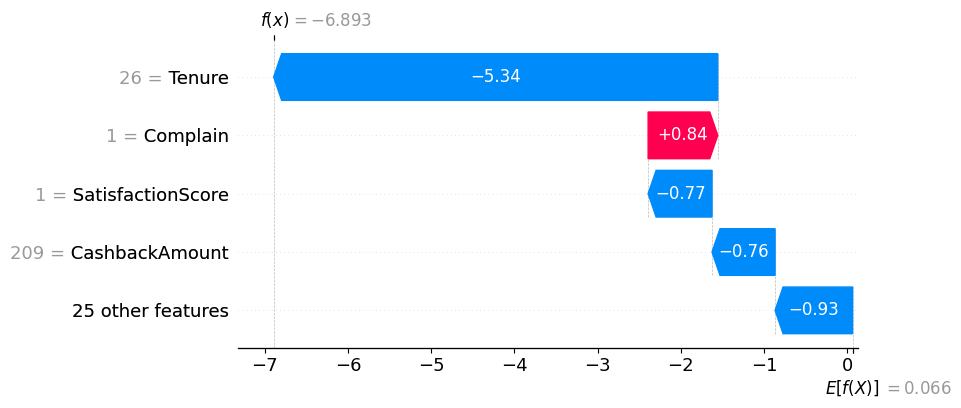

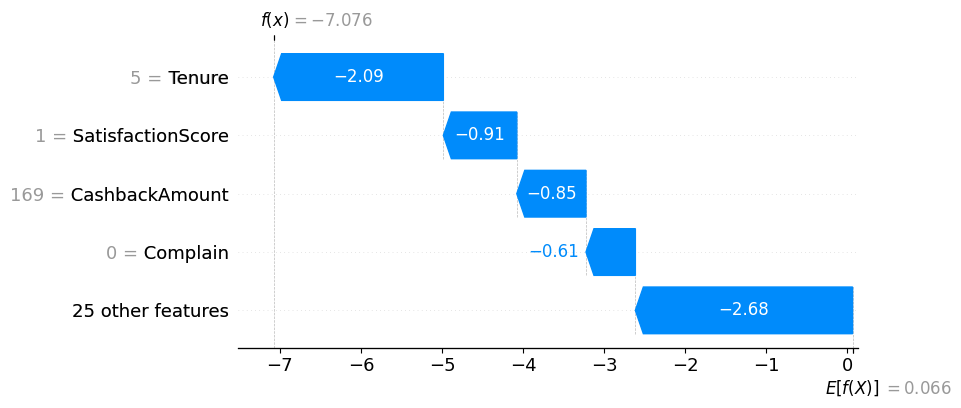

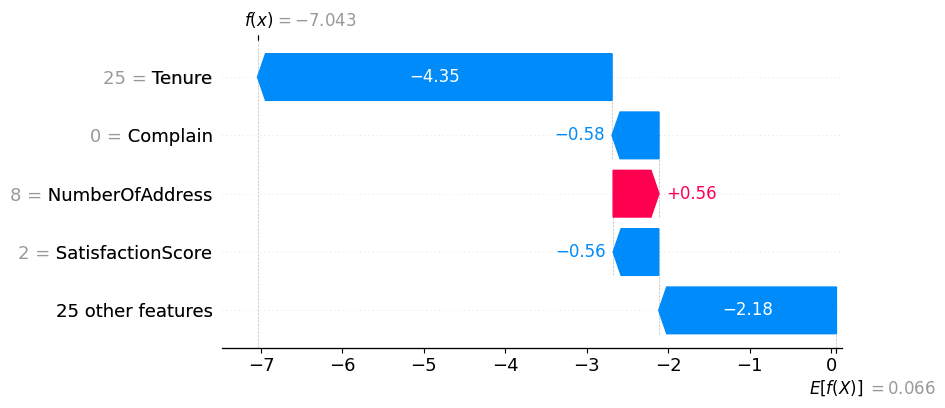

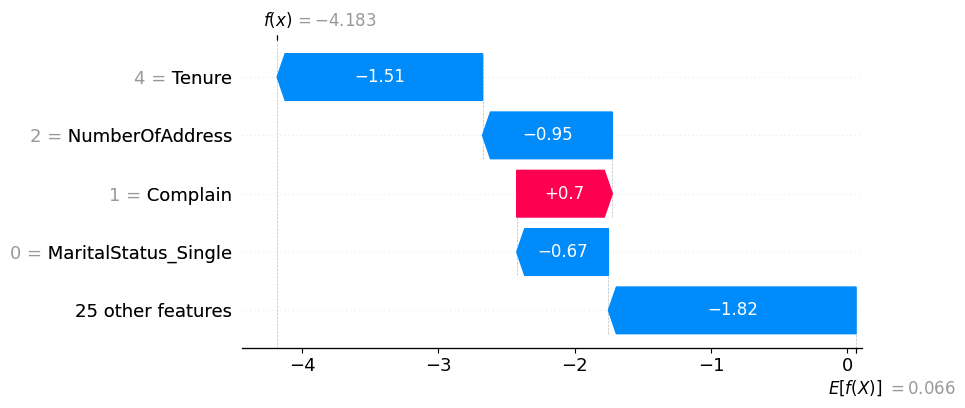

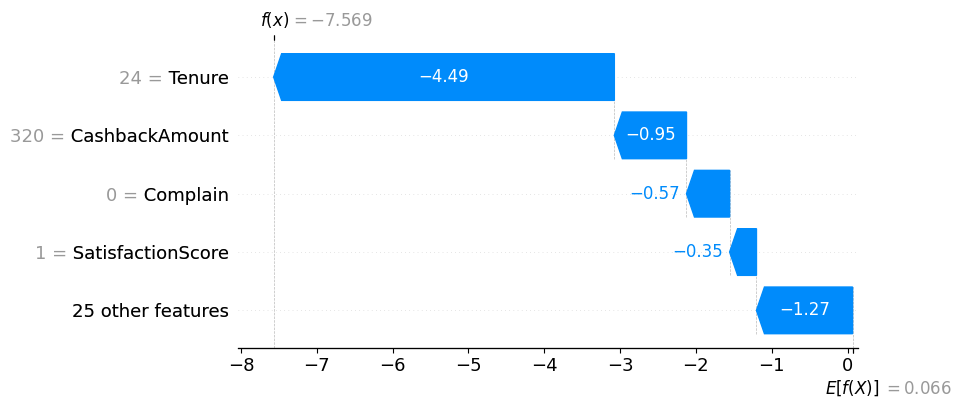

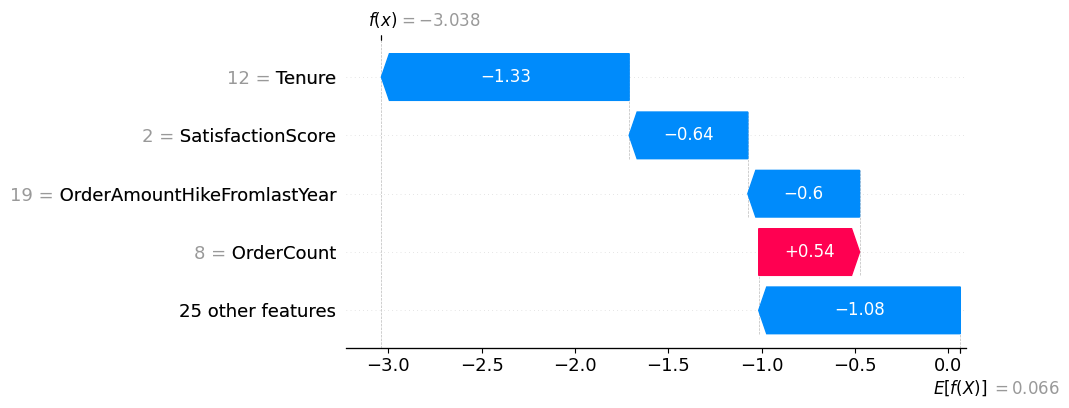

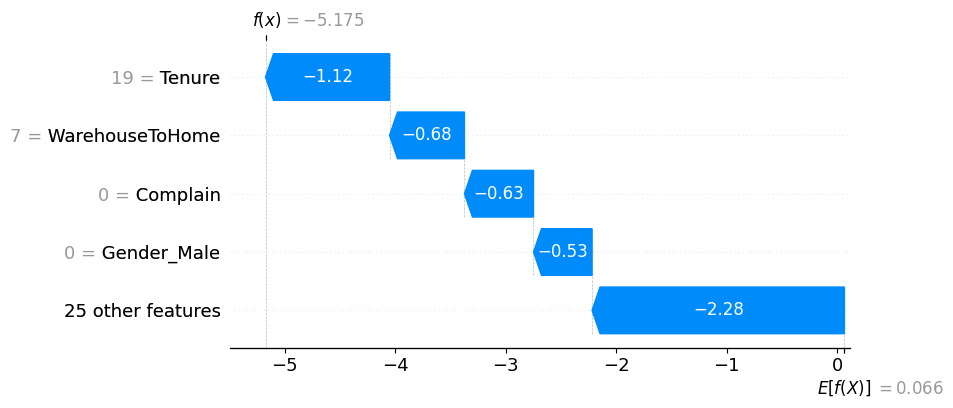

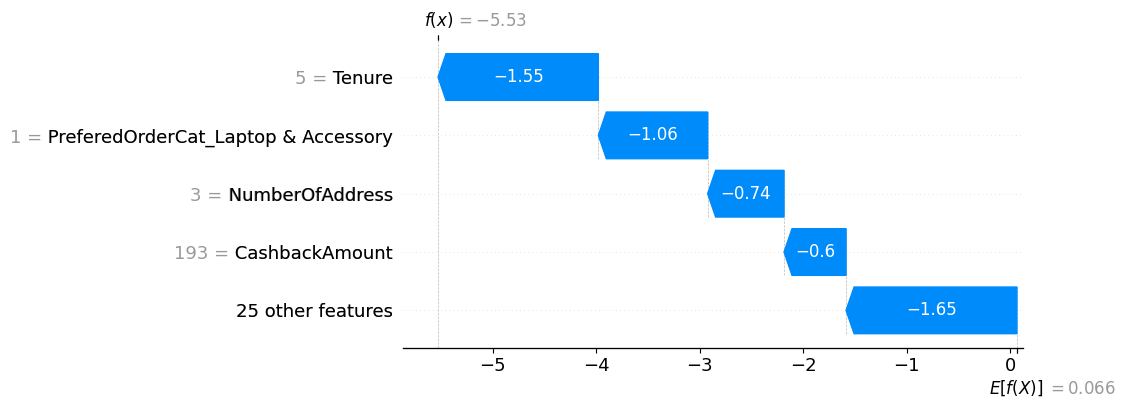

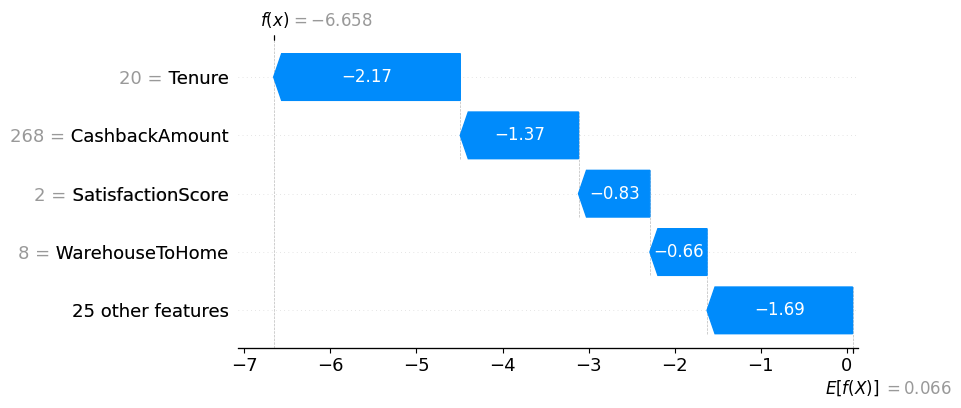

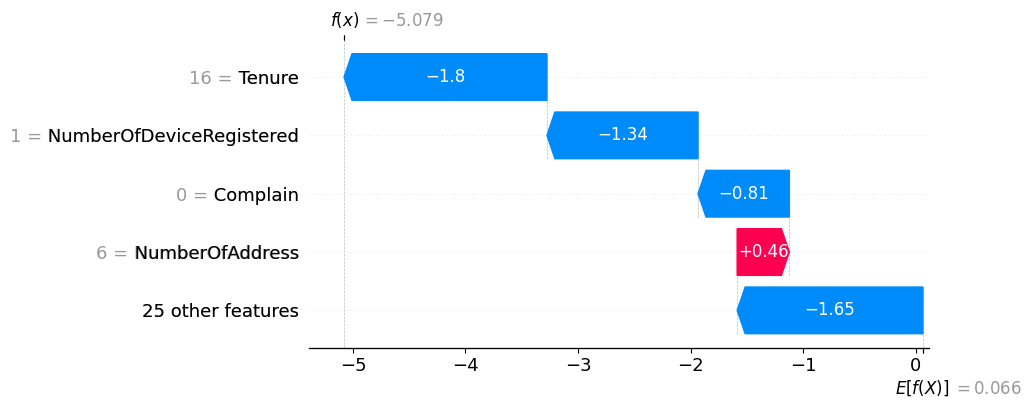

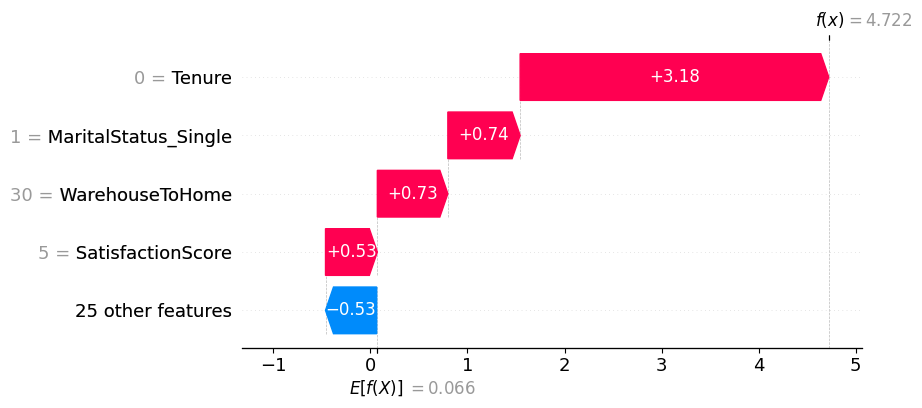

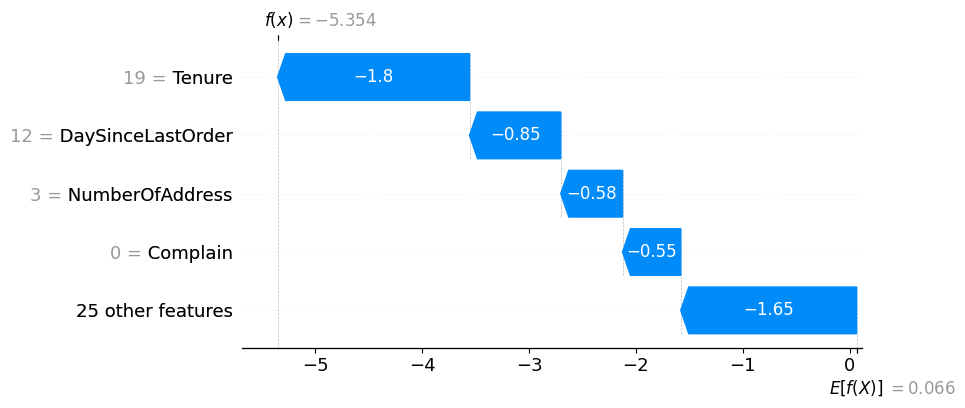

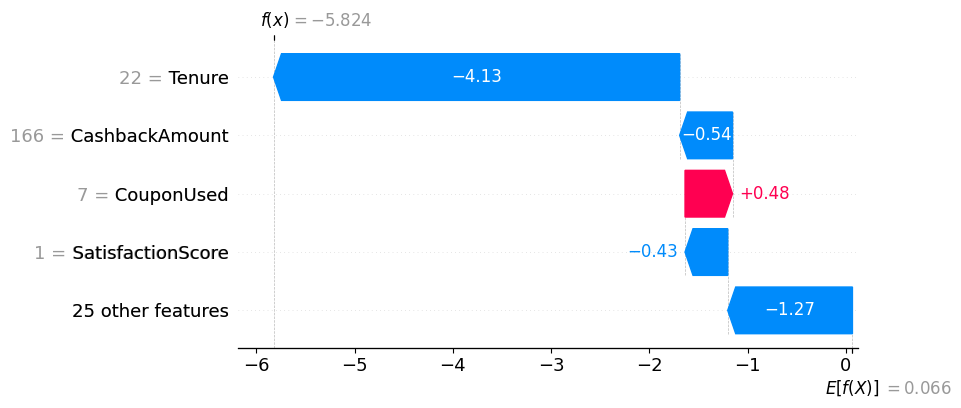

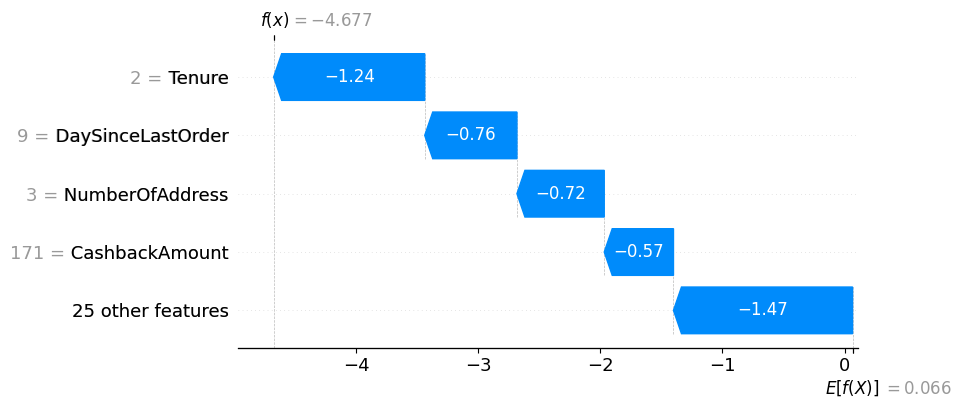

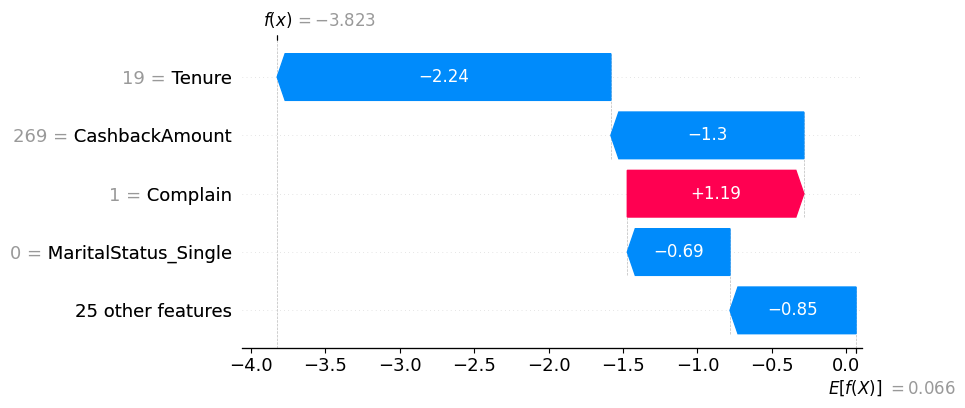

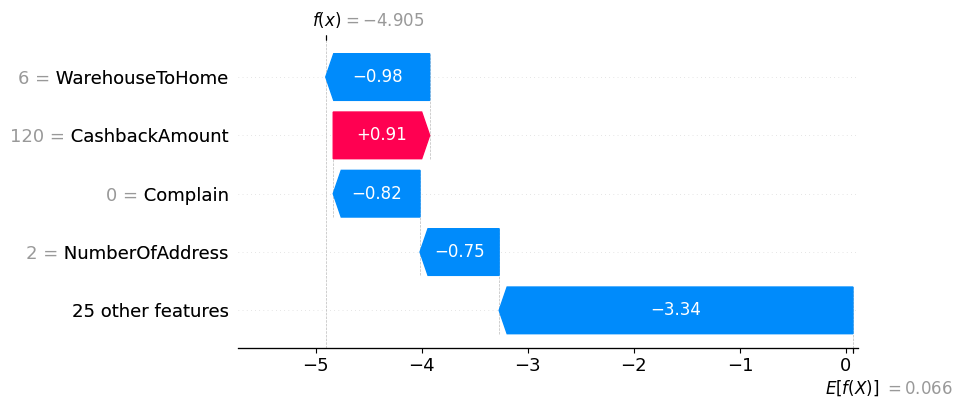

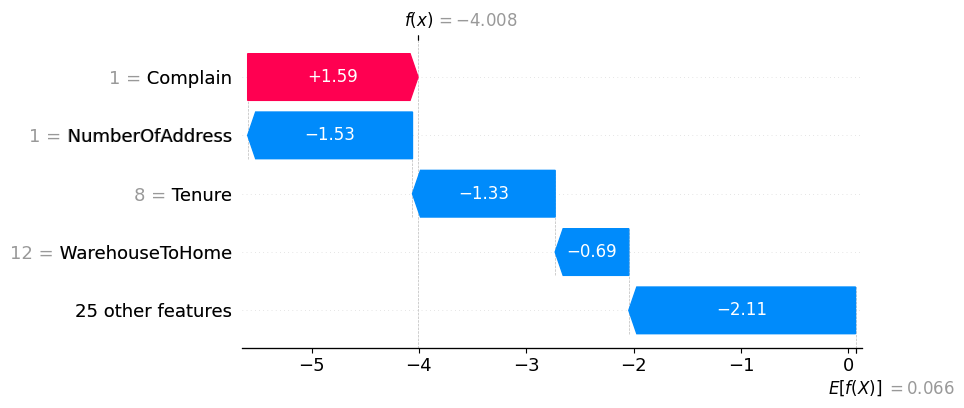

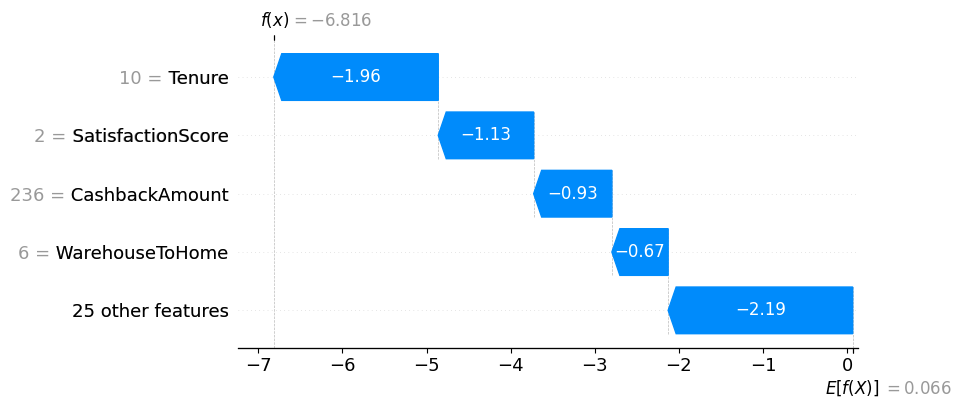

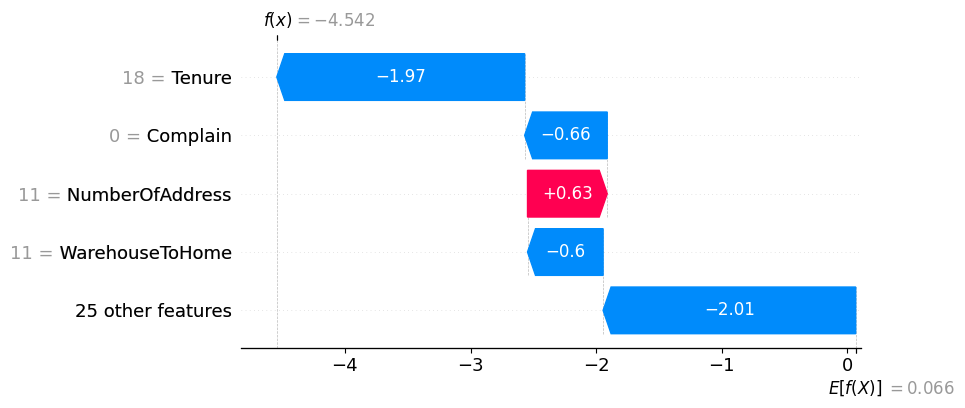

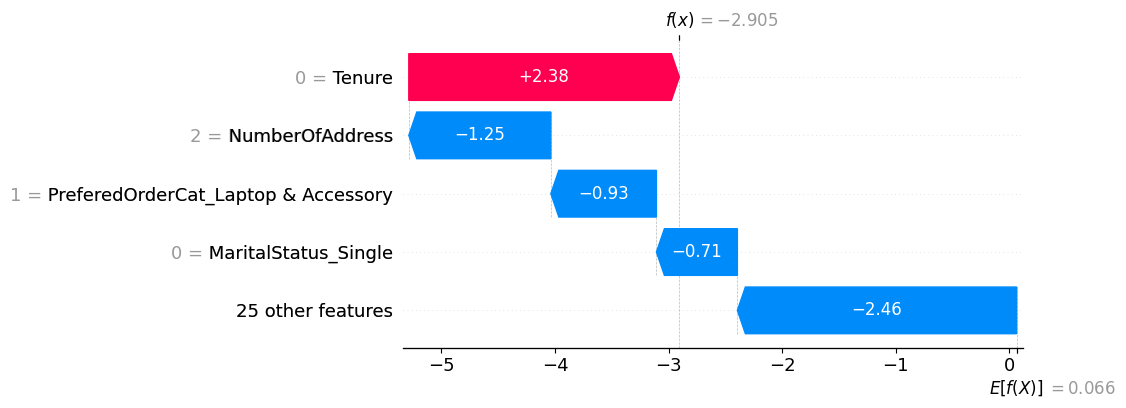

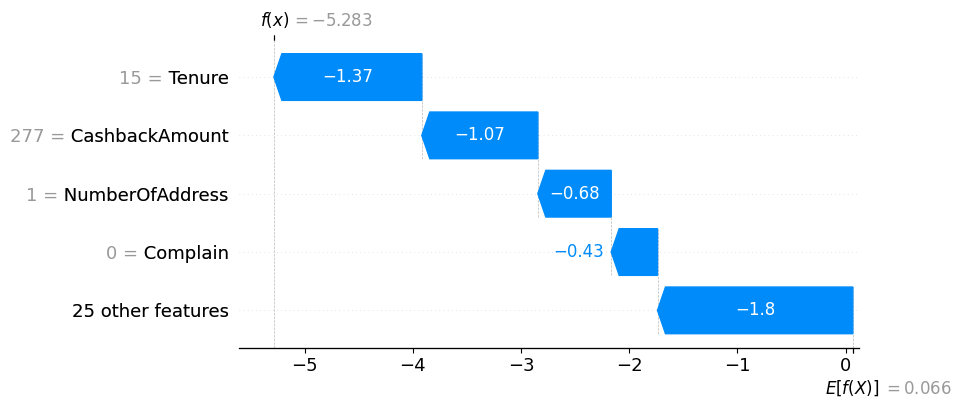

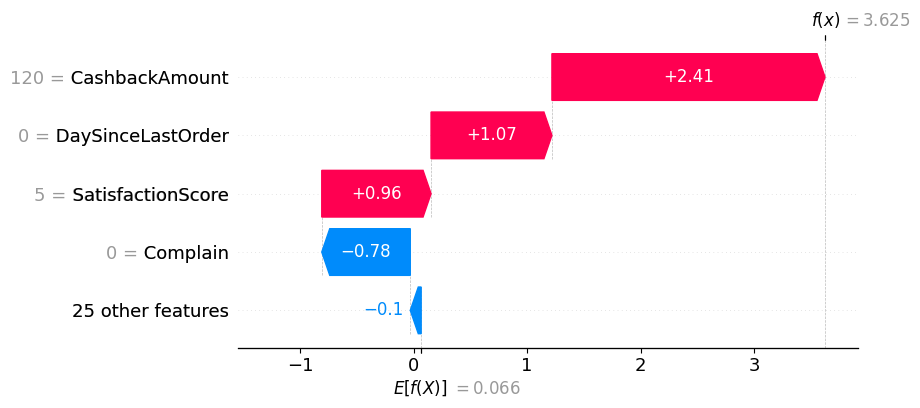

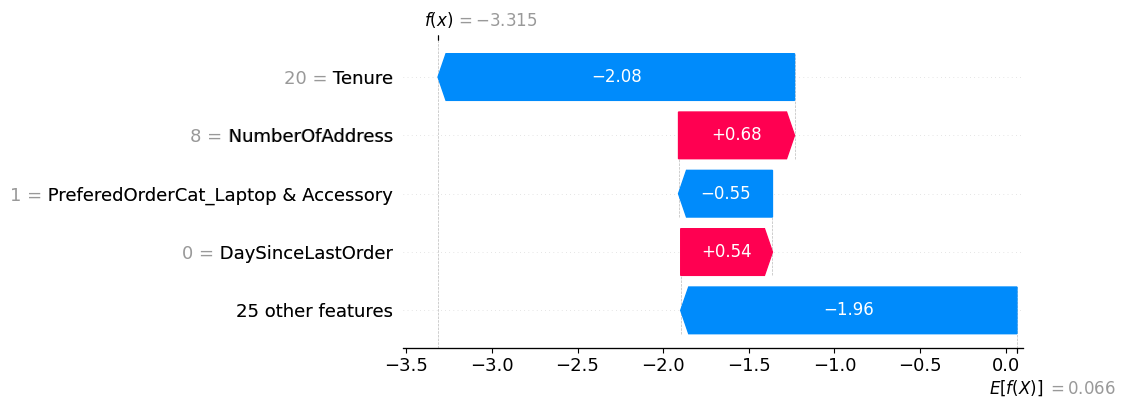

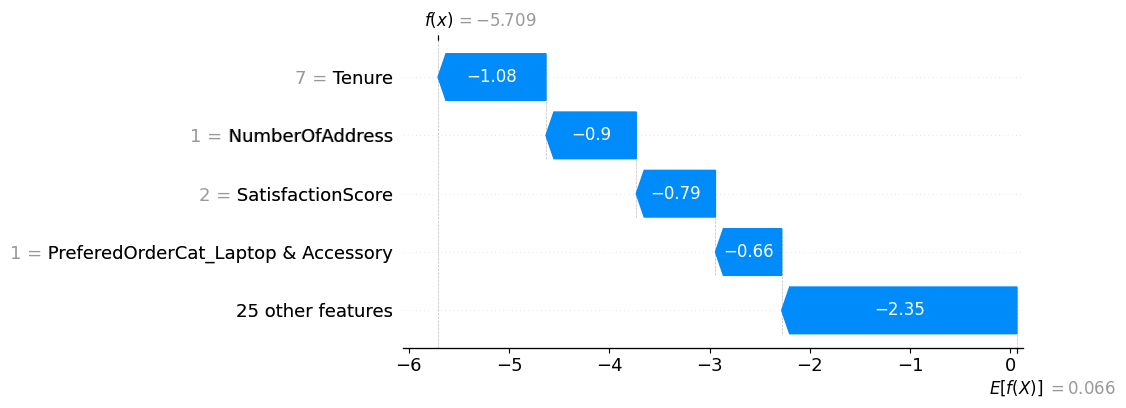

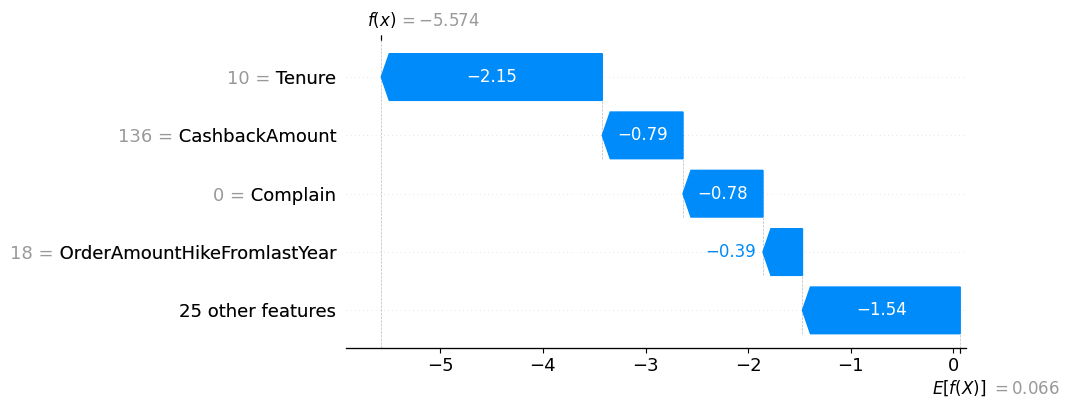

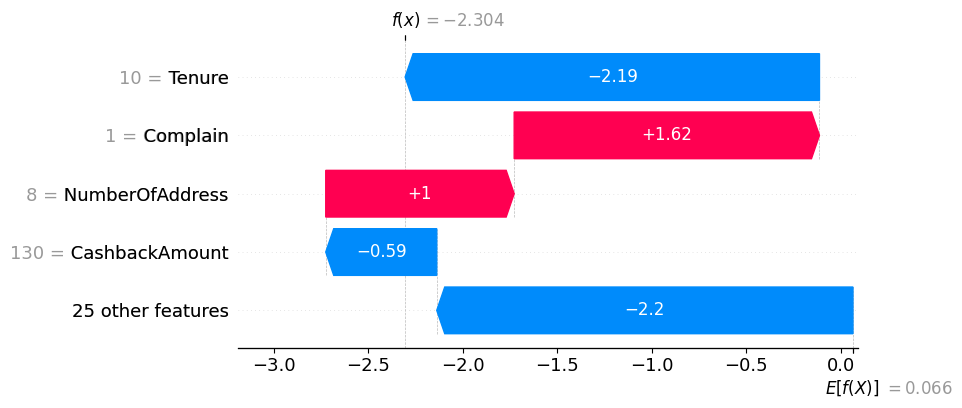

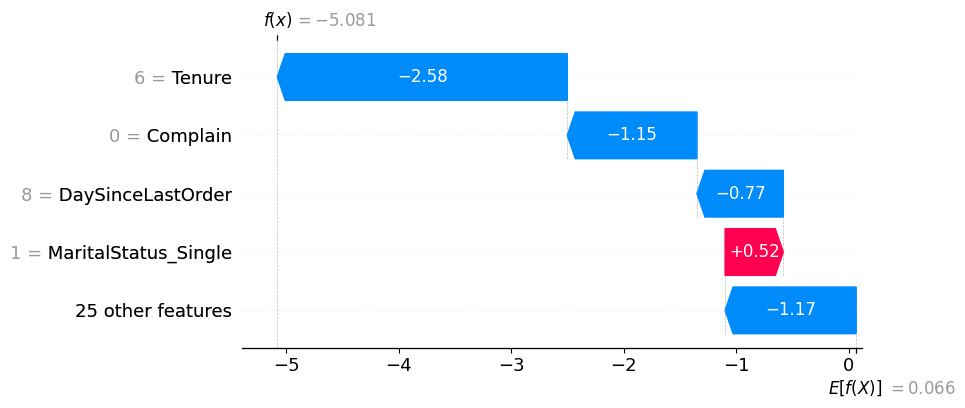

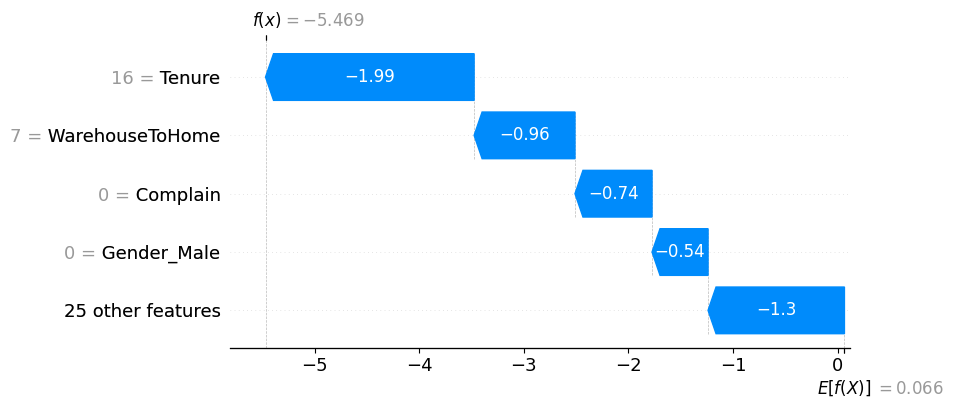

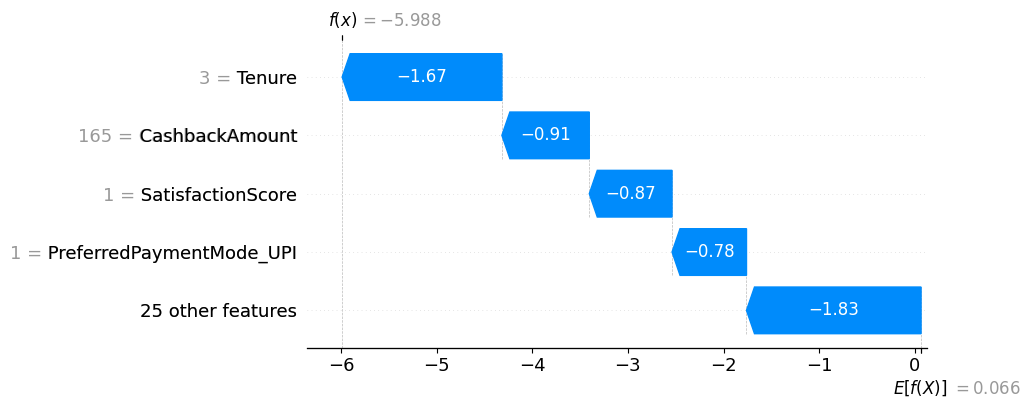

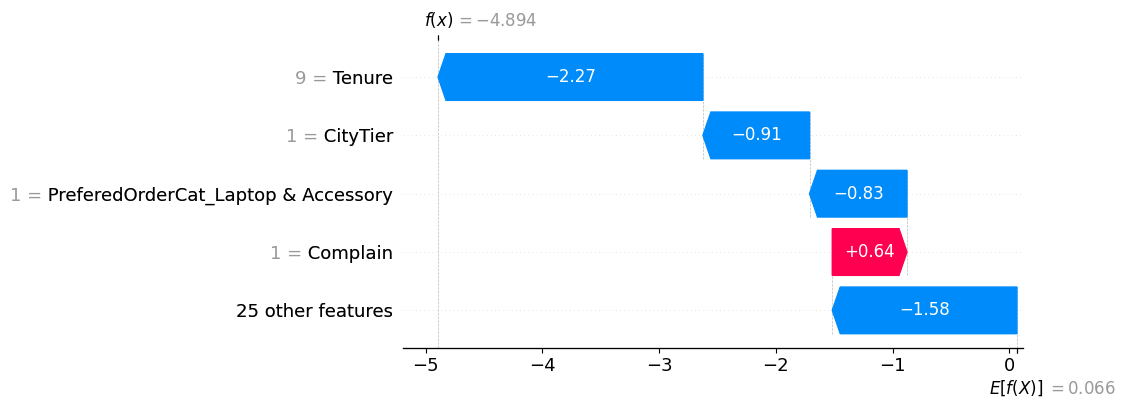

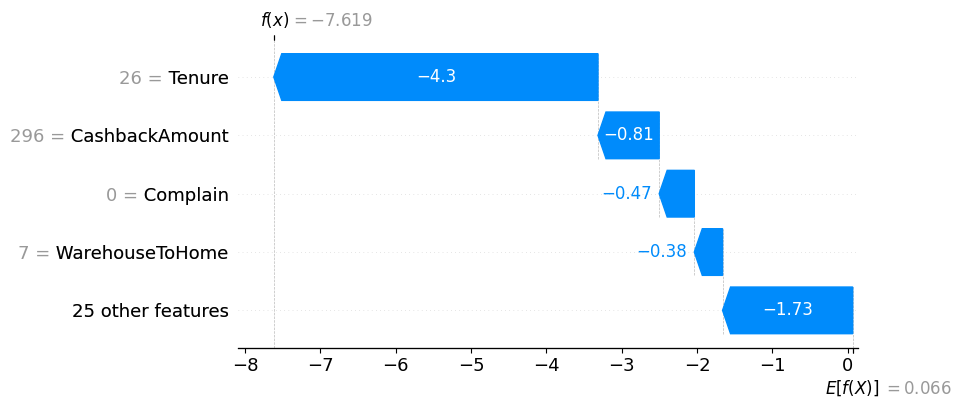

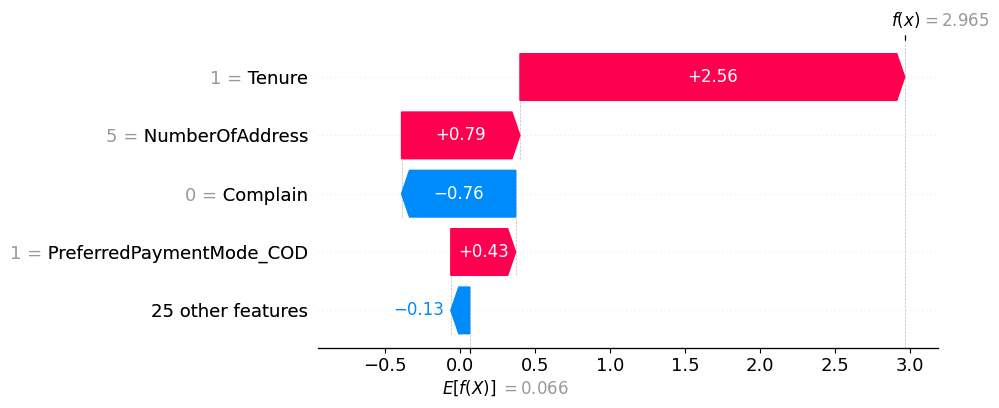

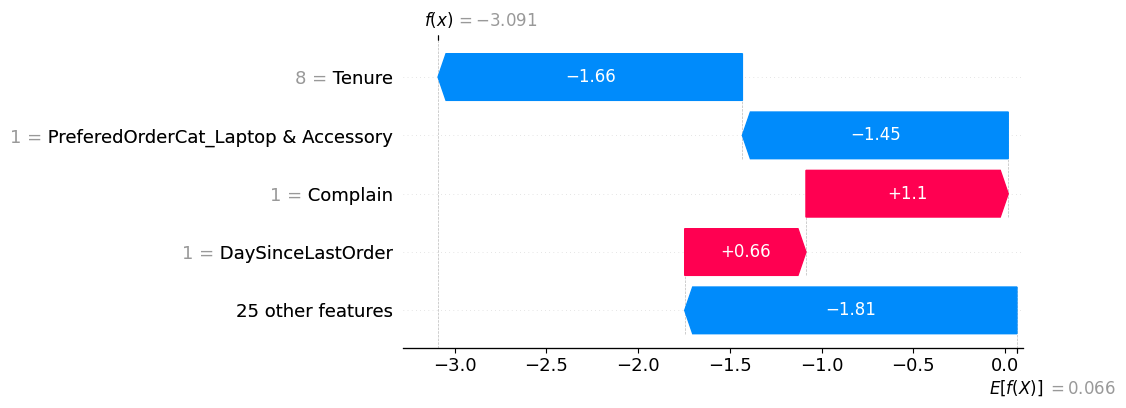

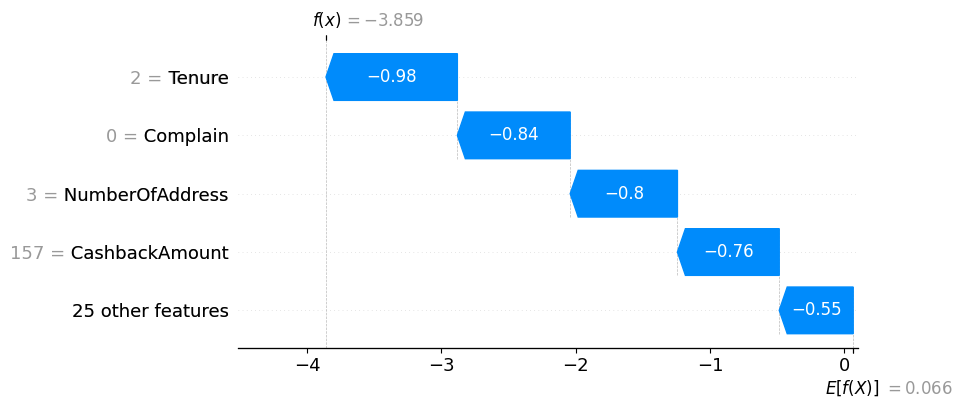

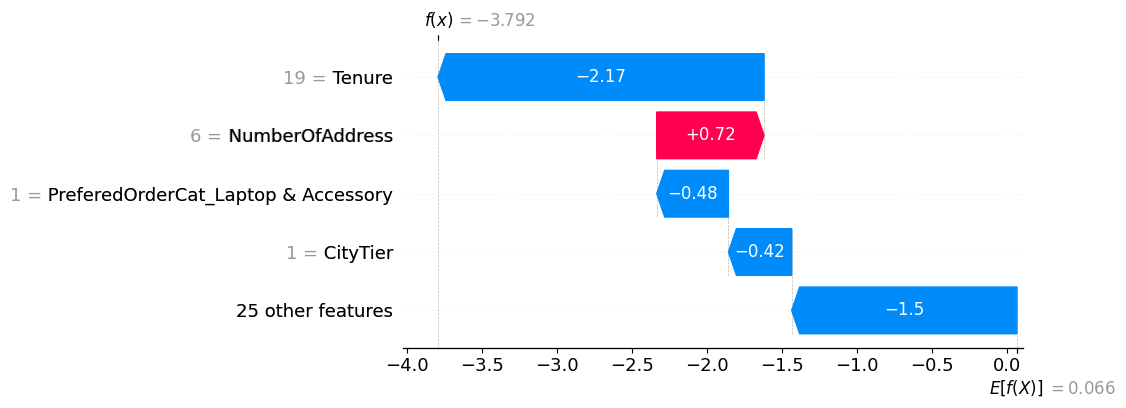

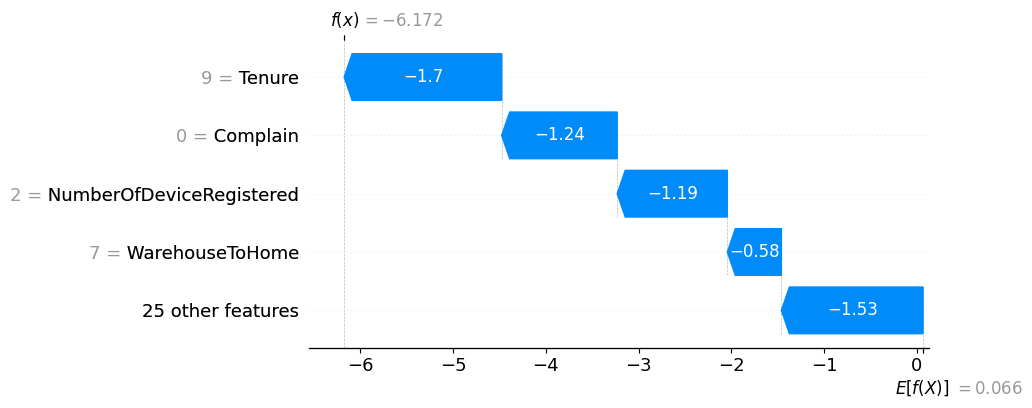

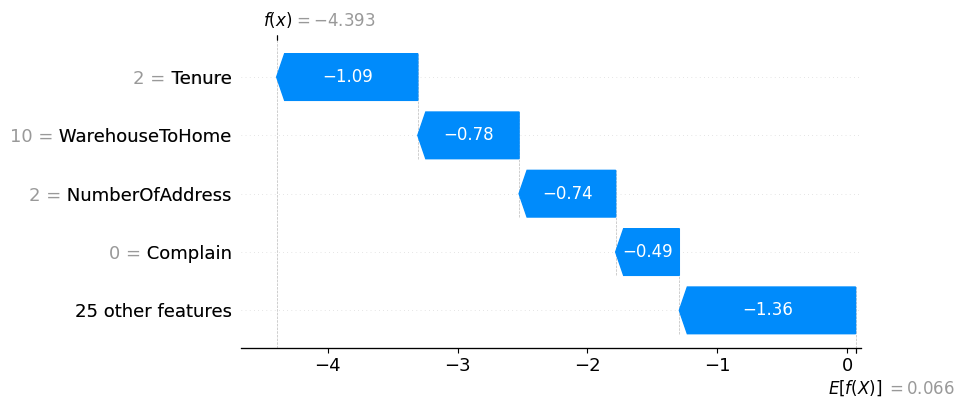

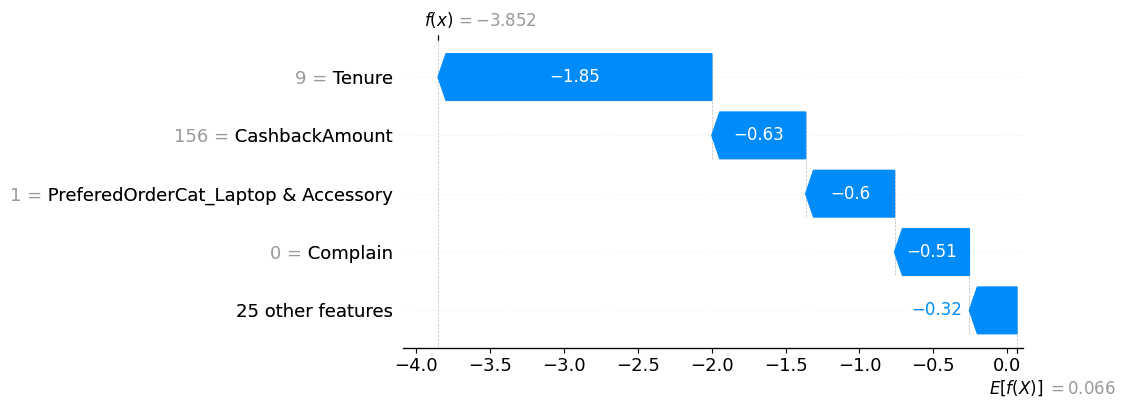

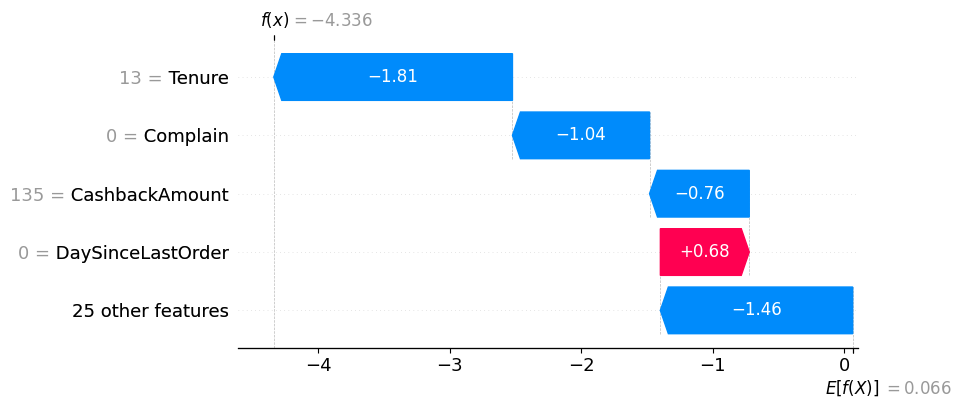

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

params = {
    'n_estimators': 323,
    'max_depth': 9,
    'learning_rate': 0.035012308132068994,
    'subsample': 0.9460126686315559,
    'colsample_bytree': 0.7969754254702797,
    'scale_pos_weight': float(4.938818565400844),  # class weight cho imbalance
    'random_state': 42,
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

model = XGBClassifier(**params)
model.fit(X_train, y_train)


explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

plt.title("SHAP Summary Plot (Global)")
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=5)


shap.summary_plot(shap_values, X_test, max_display=2)

for sample_idx in range(40):
  shap.plots.waterfall(shap_values[sample_idx], max_display=5)

/tmp/ipython-input-3457901729.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


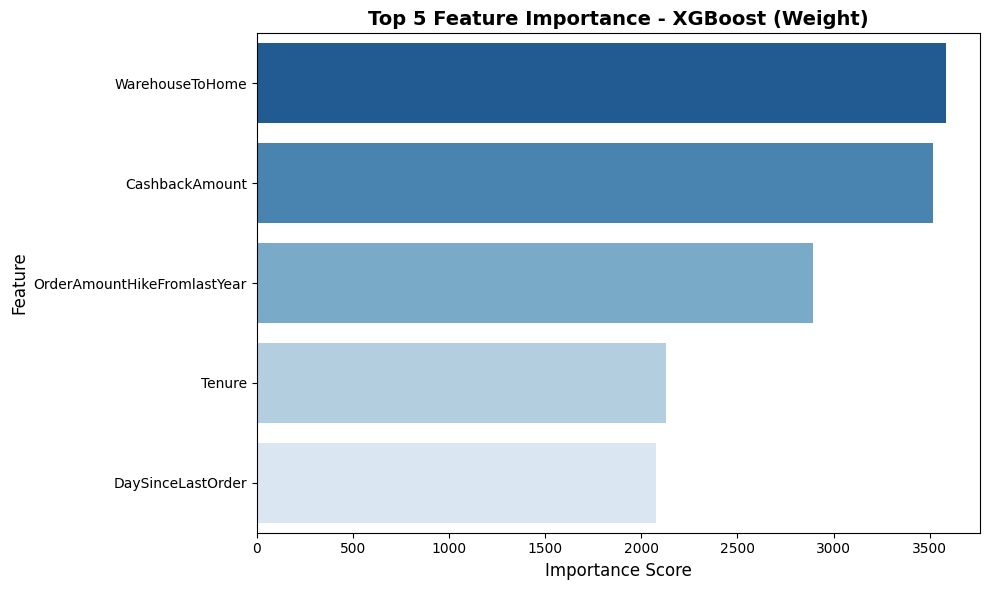

/tmp/ipython-input-3457901729.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


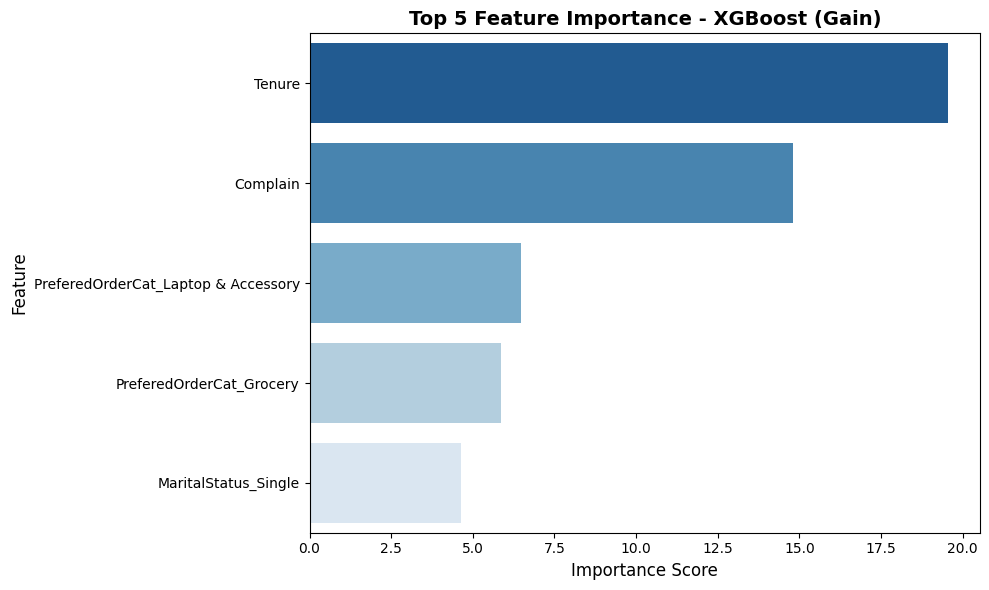

In [ ]:
import seaborn as sns

# ----------------------------
# 4. Feature Importance với Seaborn (Top 10, Blues)
# ----------------------------
importance_types = ["weight", "gain"]

for imp_type in importance_types:
    # Lấy importance từ model
    importance_dict = model.get_booster().get_score(importance_type=imp_type)
    importance_df = pd.DataFrame({
        "Feature": list(importance_dict.keys()),
        "Importance": list(importance_dict.values())
    }).sort_values("Importance", ascending=False).head(5)  # lấy top 10

    # Vẽ seaborn barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=importance_df,
        x="Importance",
        y="Feature",
        palette="Blues_r"   # dùng Blues (đảo ngược để đậm hơn ở trên cùng)
    )
    plt.title(f"Top 5 Feature Importance - XGBoost ({imp_type.capitalize()})",
              fontsize=14, weight="bold")
    plt.xlabel("Importance Score", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.tight_layout()
    plt.show()

# **Overfiting check**

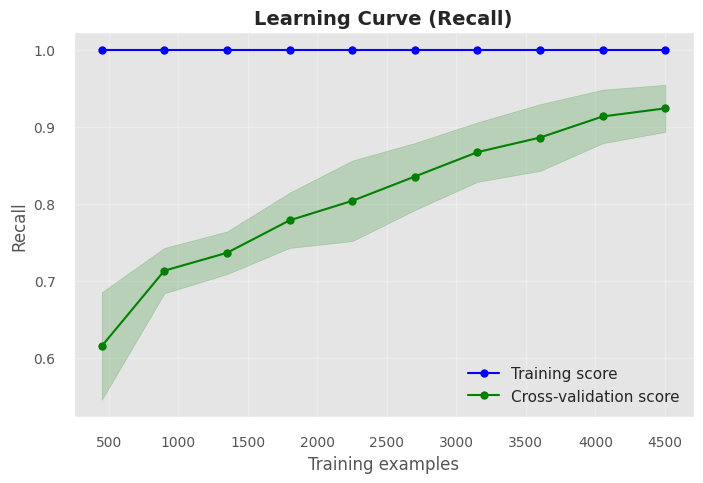

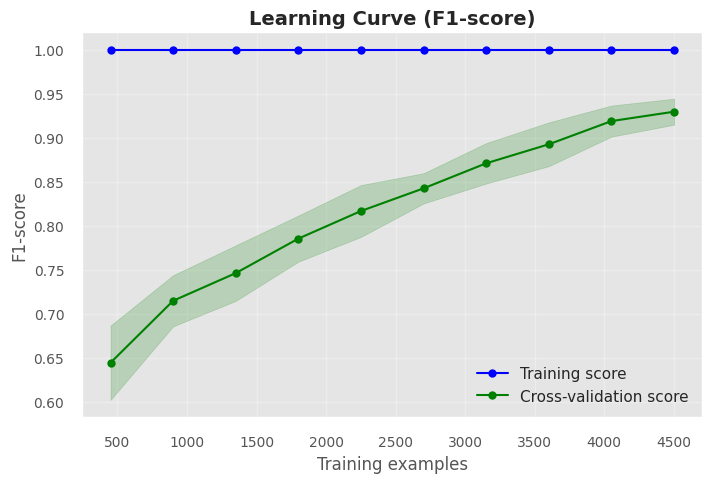

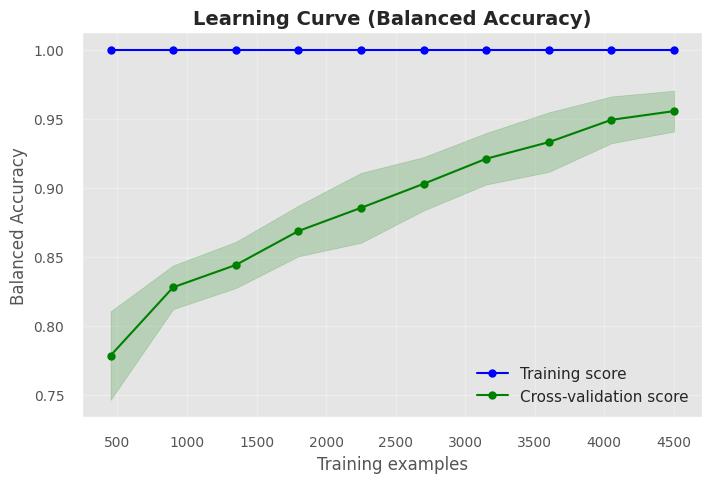

In [ ]:

scorers = {
    "Recall": make_scorer(recall_score),
    "F1-score": make_scorer(f1_score),
    "Balanced Accuracy": make_scorer(balanced_accuracy_score)
}

for metric, scorer in scorers.items():
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y,
        cv=skf,
        scoring=scorer,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        shuffle=True,
        random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # ---------------- Plot ----------------
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training score")
    plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="blue")

    plt.plot(train_sizes, test_mean, 'o-', color="green", label="Cross-validation score")
    plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2, color="green")

    plt.title(f"Learning Curve ({metric})", fontsize=14, weight="bold")
    plt.xlabel("Training examples", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.legend(loc="best")
    plt.grid(alpha=0.3)
    plt.show()